In [1]:
!git clone https://github.com/aytenaaser/Machine_Learning_DataOrbit.git

Cloning into 'Machine_Learning_DataOrbit'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 20 (delta 1), reused 9 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 5.52 KiB | 5.52 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
from google.colab import files
files.upload()   # choose kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aytenaaser","key":"edaa2cb4180de97987862f41bf8ab475"}'}

In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d rohitrox/healthcare-provider-fraud-detection-analysis


Dataset URL: https://www.kaggle.com/datasets/rohitrox/healthcare-provider-fraud-detection-analysis
License(s): CC0-1.0
  0% 0.00/25.4M [00:00<?, ?B/s]
100% 25.4M/25.4M [00:00<00:00, 966MB/s]


In [5]:
!unzip healthcare-provider-fraud-detection-analysis.zip


Archive:  healthcare-provider-fraud-detection-analysis.zip
  inflating: Test-1542969243754.csv  
  inflating: Test_Beneficiarydata-1542969243754.csv  
  inflating: Test_Inpatientdata-1542969243754.csv  
  inflating: Test_Outpatientdata-1542969243754.csv  
  inflating: Train-1542865627584.csv  
  inflating: Train_Beneficiarydata-1542865627584.csv  
  inflating: Train_Inpatientdata-1542865627584.csv  
  inflating: Train_Outpatientdata-1542865627584.csv  


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load datasets
# Load all datasets
beneficiary = pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
inpatient = pd.read_csv('Train_Inpatientdata-1542865627584.csv')
outpatient = pd.read_csv('Train_Outpatientdata-1542865627584.csv')
labels = pd.read_csv('Train-1542865627584.csv')


Data Understanding & Exploration
Part 1: Dataset Relationships & Join Keys
# **Purpose:** Examine relationships between the four datasets and define join keys and levels of granularity
#



In [7]:

print("="*60)
print("1. DATA RELATIONSHIPS & JOIN KEYS")
print("="*60)
print(f"Inpatient shape: {inpatient.shape}")
print(f"Outpatient shape: {outpatient.shape}")
print(f"Beneficiary shape: {beneficiary.shape}")
print(f"Labels shape: {labels.shape}")

print(f"\nJoin Keys & Relationships:")
print(f"  - Claims → Beneficiary: BeneID (many-to-one: multiple claims per beneficiary)")
print(f"  - Claims → Labels: Provider (many-to-one: multiple claims per provider)")
print(f"  - Granularity: Claim-level → Provider-level (aggregation needed)")
print(f"     - Claim-level: You have thousands of rows showing individual medical bills.")
print(f"     - Provider-level: You need one summary row per doctor/hospital showing their overall billing behavior.")
print(f"     - The transformation means converting from many detailed bills → one behavioral profile per provider.")
# Verify relationships
print(f"\nRelationship Verification:")
print(f"  Unique Beneficiaries in Inpatient: {inpatient['BeneID'].nunique()}")
print(f"  Unique Beneficiaries in Outpatient: {outpatient['BeneID'].nunique()}")
print(f"  Unique Beneficiaries in Beneficiary data: {beneficiary['BeneID'].nunique()}")
print(f"  Unique Providers in Inpatient: {inpatient['Provider'].nunique()}")
print(f"  Unique Providers in Outpatient: {outpatient['Provider'].nunique()}")
print(f"  Unique Providers in Labels: {labels['Provider'].nunique()}")

# Check overlaps
inpatient_providers = set(inpatient['Provider'].unique())
outpatient_providers = set(outpatient['Provider'].unique())
providers_both = len(inpatient_providers.intersection(outpatient_providers))
print(f"  Providers in both Inpatient & Outpatient: {providers_both}")

inpatient_benes = set(inpatient['BeneID'].unique())
outpatient_benes = set(outpatient['BeneID'].unique())
benes_both = len(inpatient_benes.intersection(outpatient_benes))
print(f"  Beneficiaries in both Inpatient & Outpatient: {benes_both}")

# Cardinality examples
print(f"\nCardinality Examples:")
print(f"  Avg claims per beneficiary (Inpatient): {len(inpatient) / inpatient['BeneID'].nunique():.2f}")
print(f"  Avg claims per beneficiary (Outpatient): {len(outpatient) / outpatient['BeneID'].nunique():.2f}")
print(f"  Avg claims per provider (Inpatient): {len(inpatient) / inpatient['Provider'].nunique():.2f}")
print(f"  Avg claims per provider (Outpatient): {len(outpatient) / outpatient['Provider'].nunique():.2f}")
 #Granularity
print(f"\nGranularity Levels:")
print(f"  Current Level: CLAIM-LEVEL")
print(f"    - Inpatient: {len(inpatient)} records (one row per claim)")
print(f"    - Outpatient: {len(outpatient)} records (one row per claim)")
print(f"    - Each row represents a single medical claim")
print(f"  Target Level: PROVIDER-LEVEL")
print(f"    - Labels: {len(labels)} records (one row per provider)")
print(f"    - Each row represents a provider with fraud label")
print(f"  Transformation Required:")
print(f"    - Aggregate claim-level data by Provider")
print(f"    - Create statistical summaries (counts, means, ratios)")
print(f"    - Combine Inpatient + Outpatient data per provider")
print(f"    - Result: One row per provider for modeling")


1. DATA RELATIONSHIPS & JOIN KEYS
Inpatient shape: (40474, 30)
Outpatient shape: (517737, 27)
Beneficiary shape: (138556, 25)
Labels shape: (5410, 2)

Join Keys & Relationships:
  - Claims → Beneficiary: BeneID (many-to-one: multiple claims per beneficiary)
  - Claims → Labels: Provider (many-to-one: multiple claims per provider)
  - Granularity: Claim-level → Provider-level (aggregation needed)
     - Claim-level: You have thousands of rows showing individual medical bills.
     - Provider-level: You need one summary row per doctor/hospital showing their overall billing behavior.
     - The transformation means converting from many detailed bills → one behavioral profile per provider.

Relationship Verification:
  Unique Beneficiaries in Inpatient: 31289
  Unique Beneficiaries in Outpatient: 133980
  Unique Beneficiaries in Beneficiary data: 138556
  Unique Providers in Inpatient: 2092
  Unique Providers in Outpatient: 5012
  Unique Providers in Labels: 5410
  Providers in both Inpati

Data Understanding & Exploration
Part 2: Data Quality Assessment
# **Purpose:** Assess data quality and completeness, identifying missing values and inconsistencies
#

In [8]:
print("2. DATA QUALITY ASSESSMENT")
print("="*60)

# Missing values
print("\nMissing Values:")
print(f"Inpatient: {inpatient.isnull().sum().sum()} ({(inpatient.isnull().sum().sum() / (inpatient.shape[0] * inpatient.shape[1])) * 100:.2f}%)")
print(f"Outpatient: {outpatient.isnull().sum().sum()} ({(outpatient.isnull().sum().sum() / (outpatient.shape[0] * outpatient.shape[1])) * 100:.2f}%)")
print(f"Beneficiary: {beneficiary.isnull().sum().sum()} ({(beneficiary.isnull().sum().sum() / (beneficiary.shape[0] * beneficiary.shape[1])) * 100:.2f}%)")

# Check for duplicates
print(f"\nDuplicate Analysis:")

print(f"Duplicate Claims (Inpatient): {inpatient['ClaimID'].duplicated().sum()}")
print(f"Duplicate Claims (Outpatient): {outpatient['ClaimID'].duplicated().sum()}")
print(f"This checks if the same ClaimID appears multiple times across different providers, which could indicate coding errors or data issues.")
print("_"*60)

print(f"Duplicate Claims per Provider (Inpatient): {inpatient.duplicated(subset=['Provider', 'ClaimID']).sum()}")
print(f"Duplicate Claims per Provider (Outpatient): {outpatient.duplicated(subset=['Provider', 'ClaimID']).sum()}")
print(f"This checks if the same provider is submitting the same ClaimID multiple times, which could be a red flag for duplicate billing fraud.")
print("_"*60)

print(f"Duplicate Beneficiary IDs: {beneficiary['BeneID'].duplicated().sum()}")
print(f"This checks for duplicate patient records in beneficiary data - should be zero as each patient should have one unique record.")
print("_"*60)

print(f"Duplicate Provider IDs in labels: {labels['Provider'].duplicated().sum()}")
print(f"This checks for duplicate providers in labels data - should be zero as each provider should have one fraud classification.")
print("_"*60)

print(f"Duplicate Rows (Inpatient): {inpatient.duplicated().sum()}")
print(f"Duplicate Rows (Outpatient): {outpatient.duplicated().sum()}")
print(f"This checks for completely identical rows in claims data, which could indicate data processing errors.")
print("_"*60)

print(f"Unique Providers: {labels['Provider'].nunique()}")
print(f"This shows the total number of unique providers we need to classify as fraudulent or legitimate.")
print("_"*60)

# Date consistency
inpatient['ClaimStartDt'] = pd.to_datetime(inpatient['ClaimStartDt'])
inpatient['ClaimEndDt'] = pd.to_datetime(inpatient['ClaimEndDt'])
outpatient['ClaimStartDt'] = pd.to_datetime(outpatient['ClaimStartDt'])
outpatient['ClaimEndDt'] = pd.to_datetime(outpatient['ClaimEndDt'])

print(f"\nDate Range - Inpatient: {inpatient['ClaimStartDt'].min()} to {inpatient['ClaimStartDt'].max()}")
print(f"Date Range - Outpatient: {outpatient['ClaimStartDt'].min()} to {outpatient['ClaimStartDt'].max()}")

# Inconsistencies
print("\nInconsistencies:")
# Date logic errors
inpatient_date_error = (inpatient['ClaimEndDt'] < inpatient['ClaimStartDt']).sum()
outpatient_date_error = (outpatient['ClaimEndDt'] < outpatient['ClaimStartDt']).sum()
print(f"Date Logic Errors (End < Start) - Inpatient: {inpatient_date_error}, Outpatient: {outpatient_date_error}")

# Negative amounts
inpatient_neg = (inpatient['InscClaimAmtReimbursed'] < 0).sum()
outpatient_neg = (outpatient['InscClaimAmtReimbursed'] < 0).sum()
print(f"Negative Amounts - Inpatient: {inpatient_neg}, Outpatient: {outpatient_neg}")

# Zero amounts
inpatient_zero = (inpatient['InscClaimAmtReimbursed'] == 0).sum()
outpatient_zero = (outpatient['InscClaimAmtReimbursed'] == 0).sum()
print(f"Zero Amounts - Inpatient: {inpatient_zero}, Outpatient: {outpatient_zero}")

# Provider-Beneficiary mismatch check
inpatient_providers = set(inpatient['Provider'].unique())
outpatient_providers = set(outpatient['Provider'].unique())
label_providers = set(labels['Provider'].unique())
providers_in_claims = inpatient_providers.union(outpatient_providers)
providers_not_in_labels = providers_in_claims - label_providers
providers_in_labels_not_in_claims = label_providers - providers_in_claims
print(f"Providers in claims but not in labels: {len(providers_not_in_labels)}")
print(f"Providers in labels but not in claims: {len(providers_in_labels_not_in_claims)}")

# Beneficiary coverage check
inpatient_benes = set(inpatient['BeneID'].unique())
outpatient_benes = set(outpatient['BeneID'].unique())
all_claim_benes = inpatient_benes.union(outpatient_benes)
beneficiary_benes = set(beneficiary['BeneID'].unique())
benes_in_claims_not_in_beneficiary = all_claim_benes - beneficiary_benes
print(f"Beneficiaries in claims but not in beneficiary data: {len(benes_in_claims_not_in_beneficiary)}")


2. DATA QUALITY ASSESSMENT

Missing Values:
Inpatient: 344003 (28.33%)
Outpatient: 8093719 (57.90%)
Beneficiary: 137135 (3.96%)

Duplicate Analysis:
Duplicate Claims (Inpatient): 0
Duplicate Claims (Outpatient): 0
This checks if the same ClaimID appears multiple times across different providers, which could indicate coding errors or data issues.
____________________________________________________________
Duplicate Claims per Provider (Inpatient): 0
Duplicate Claims per Provider (Outpatient): 0
This checks if the same provider is submitting the same ClaimID multiple times, which could be a red flag for duplicate billing fraud.
____________________________________________________________
Duplicate Beneficiary IDs: 0
This checks for duplicate patient records in beneficiary data - should be zero as each patient should have one unique record.
____________________________________________________________
Duplicate Provider IDs in labels: 0
This checks for duplicate providers in labels data -

Data Understanding & Exploration
Part 3: Beneficiary Data Exploration
# **Purpose:** Conduct exploratory analysis on beneficiaries to uncover patterns, distributions, and outliers

In [9]:

print("\n" + "="*60)
print("3. EXPLORATORY ANALYSIS")
print("="*60)

# Combine inpatient and outpatient
inpatient['ClaimType'] = 'Inpatient'
outpatient['ClaimType'] = 'Outpatient'
all_claims = pd.concat([inpatient[['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed',
                                    'ClaimStartDt', 'ClaimEndDt', 'ClaimType']],
                        outpatient[['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed',
                                    'ClaimStartDt', 'ClaimEndDt', 'ClaimType']]],
                       ignore_index=True)

print(f"\nTotal Claims: {len(all_claims)}")
print(f"Total Amount: ${all_claims['InscClaimAmtReimbursed'].sum():,.2f}")
print(f"Average Claim Amount: ${all_claims['InscClaimAmtReimbursed'].mean():,.2f}")
print(f"Median Claim Amount: ${all_claims['InscClaimAmtReimbursed'].median():,.2f}")

# Claims: Distributions & Outliers
print(f"\nClaims Analysis:")
print(f"  Amount Distribution - Q1: ${all_claims['InscClaimAmtReimbursed'].quantile(0.25):,.2f}, "
      f"Q3: ${all_claims['InscClaimAmtReimbursed'].quantile(0.75):,.2f}")
print(f"  Outliers (>Q3+1.5*IQR): {(all_claims['InscClaimAmtReimbursed'] >
      all_claims['InscClaimAmtReimbursed'].quantile(0.75) + 1.5 *
      (all_claims['InscClaimAmtReimbursed'].quantile(0.75) - all_claims['InscClaimAmtReimbursed'].quantile(0.25))).sum()}")
print(f"  Max Claim Amount: ${all_claims['InscClaimAmtReimbursed'].max():,.2f}")
print(f"  Inpatient vs Outpatient: {len(inpatient)} vs {len(outpatient)} claims")

# Beneficiaries: Patterns & Distributions
print(f"\nBeneficiaries Analysis:")
print(f"  Total Unique: {beneficiary['BeneID'].nunique()}")
print(f"  Gender Distribution: {beneficiary['Gender'].value_counts().to_dict()}")
print(f"  Race Distribution: {dict(beneficiary['Race'].value_counts().head())}")
print(f"  Chronic Conditions - Avg per beneficiary: {beneficiary[[c for c in beneficiary.columns if 'ChronicCond' in c]].sum(axis=1).mean():.2f}")
print(f"  Age Range: {2009 - pd.to_datetime(beneficiary['DOB']).dt.year.min()} to {2009 - pd.to_datetime(beneficiary['DOB']).dt.year.max()} years")

# Providers: Patterns & Distributions
provider_claim_counts = all_claims.groupby('Provider').size()
print(f"\nProviders Analysis:")
print(f"  Total Unique: {all_claims['Provider'].nunique()}")
print(f"  Claims per Provider - Mean: {provider_claim_counts.mean():.1f}, "
      f"Median: {provider_claim_counts.median():.1f}, Max: {provider_claim_counts.max()}")
print(f"  Top 10 providers by claim count: {provider_claim_counts.nlargest(10).sum()} claims ({provider_claim_counts.nlargest(10).sum()/len(all_claims)*100:.1f}%)")

# Plot 2: Claim amount trends
plt.figure(figsize=(12, 5))
all_claims['YearMonth'] = all_claims['ClaimStartDt'].dt.to_period('M')
monthly_claims = all_claims.groupby('YearMonth')['InscClaimAmtReimbursed'].sum()
monthly_claims.plot(kind='line', marker='o')
plt.title('Monthly Claim Amount Trends')
plt.xlabel('Month')
plt.ylabel('Total Amount ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('claim_amount_trends.png', dpi=150)
plt.close()

# Plot: Claim amount distribution (log scale to show outliers)
plt.figure(figsize=(10, 6))
plt.hist(all_claims['InscClaimAmtReimbursed'], bins=100, edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.xlabel('Claim Amount ($)')
plt.ylabel('Frequency (log scale)')
plt.title('Claim Amount Distribution (Outliers Visible)')
plt.tight_layout()
plt.savefig('claim_amount_distribution.png', dpi=150)
plt.close()

# Plot: Beneficiary gender and race distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
beneficiary['Gender'].value_counts().plot(kind='bar', ax=axes[0], color=['blue', 'pink'])
axes[0].set_title('Beneficiary Gender Distribution')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')
beneficiary['Race'].value_counts().head(10).plot(kind='bar', ax=axes[1])
axes[1].set_title('Beneficiary Race Distribution (Top 10)')
axes[1].set_xlabel('Race')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.savefig('beneficiary_distributions.png', dpi=150)
plt.close()

# Plot: Provider claim count distribution
plt.figure(figsize=(10, 6))
plt.hist(provider_claim_counts, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Claims per Provider')
plt.ylabel('Number of Providers')
plt.title('Provider Claim Count Distribution')
plt.tight_layout()
plt.savefig('provider_claim_distribution.png', dpi=150)
plt.close()



3. EXPLORATORY ANALYSIS

Total Claims: 558211
Total Amount: $556,543,140.00
Average Claim Amount: $997.01
Median Claim Amount: $80.00

Claims Analysis:
  Amount Distribution - Q1: $40.00, Q3: $300.00
  Outliers (>Q3+1.5*IQR): 94652
  Max Claim Amount: $125,000.00
  Inpatient vs Outpatient: 40474 vs 517737 claims

Beneficiaries Analysis:
  Total Unique: 138556
  Gender Distribution: {2: 79106, 1: 59450}
  Race Distribution: {1: np.int64(117057), 2: np.int64(13538), 3: np.int64(5059), 5: np.int64(2902)}
  Chronic Conditions - Avg per beneficiary: 18.26
  Age Range: 100 to 26 years

Providers Analysis:
  Total Unique: 5410
  Claims per Provider - Mean: 103.2, Median: 31.0, Max: 8240
  Top 10 providers by claim count: 38231 claims (6.8%)


## Data Understanding & Exploration Part 4:Target Class Distribution




In [10]:

print("4. TARGET CLASS DISTRIBUTION")
print("="*60)
fraud_dist = labels['PotentialFraud'].value_counts()
print(fraud_dist)
print(f"\nFraud Rate: {fraud_dist['Yes']/len(labels)*100:.2f}%")


# Plot 2: Target distribution
plt.figure(figsize=(8, 5))
labels['PotentialFraud'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Provider Fraud Distribution')
plt.xlabel('Potential Fraud')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('target_distribution.png', dpi=150)
plt.close()

print("\n" + "="*60)


4. TARGET CLASS DISTRIBUTION
PotentialFraud
No     4904
Yes     506
Name: count, dtype: int64

Fraud Rate: 9.35%




## Data Understanding & Exploration Part 5: FRAUDULENT vs LEGITIMATE PROVIDER *COMPARISON*

In [11]:

print("5. FRAUDULENT vs LEGITIMATE PROVIDER COMPARISON")
print("="*60)

# Merge claims with labels
claims_with_labels = all_claims.merge(labels, on='Provider', how='left')

# Provider-level aggregation
provider_stats = claims_with_labels.groupby('Provider').agg({
    'InscClaimAmtReimbursed': ['sum', 'mean', 'count'],
    'BeneID': 'nunique',
    'ClaimType': lambda x: (x == 'Inpatient').sum()
}).reset_index()
provider_stats.columns = ['Provider', 'TotalAmount', 'AvgAmount', 'ClaimCount', 'UniqueBeneficiaries', 'InpatientCount']
provider_stats = provider_stats.merge(labels, on='Provider')

fraud_stats = provider_stats[provider_stats['PotentialFraud'] == 'Yes']
legit_stats = provider_stats[provider_stats['PotentialFraud'] == 'No']

print("\nFraudulent Providers:")
print(f"  Count: {len(fraud_stats)}")
print(f"  Avg Total Amount: ${fraud_stats['TotalAmount'].mean():,.2f}")
print(f"  Avg Claim Count: {fraud_stats['ClaimCount'].mean():.1f}")
print(f"  Avg Unique Beneficiaries: {fraud_stats['UniqueBeneficiaries'].mean():.1f}")

print("\nLegitimate Providers:")
print(f"  Count: {len(legit_stats)}")
print(f"  Avg Total Amount: ${legit_stats['TotalAmount'].mean():,.2f}")
print(f"  Avg Claim Count: {legit_stats['ClaimCount'].mean():.1f}")
print(f"  Avg Unique Beneficiaries: {legit_stats['UniqueBeneficiaries'].mean():.1f}")

# Plot 3: Provider-level summaries
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Total amount comparison
axes[0, 0].boxplot([legit_stats['TotalAmount'], fraud_stats['TotalAmount']],
                   tick_labels=['Legitimate', 'Fraudulent'])
axes[0, 0].set_title('Total Amount by Provider Type')
axes[0, 0].set_ylabel('Amount ($)')

# Claim count comparison
axes[0, 1].boxplot([legit_stats['ClaimCount'], fraud_stats['ClaimCount']],
                   tick_labels=['Legitimate', 'Fraudulent'])
axes[0, 1].set_title('Claim Count by Provider Type')
axes[0, 1].set_ylabel('Count')

# Unique beneficiaries
axes[1, 0].boxplot([legit_stats['UniqueBeneficiaries'], fraud_stats['UniqueBeneficiaries']],
                   tick_labels=['Legitimate', 'Fraudulent'])
axes[1, 0].set_title('Unique Beneficiaries by Provider Type')
axes[1, 0].set_ylabel('Count')

# Average amount per claim
axes[1, 1].boxplot([legit_stats['AvgAmount'], fraud_stats['AvgAmount']],
                   tick_labels=['Legitimate', 'Fraudulent'])
axes[1, 1].set_title('Average Amount per Claim')
axes[1, 1].set_ylabel('Amount ($)')

plt.tight_layout()
plt.savefig('provider_comparison.png', dpi=150)
plt.close()


5. FRAUDULENT vs LEGITIMATE PROVIDER COMPARISON

Fraudulent Providers:
  Count: 506
  Avg Total Amount: $584,350.04
  Avg Claim Count: 420.5
  Avg Unique Beneficiaries: 242.0

Legitimate Providers:
  Count: 4904
  Avg Total Amount: $53,193.72
  Avg Claim Count: 70.4
  Avg Unique Beneficiaries: 49.1


# Data Understanding & Exploration Part 6: AGGREGATION STRATEGY - PROVIDER-LEVEL FEATURES

In [12]:
print("\n" + "="*60)
print("6. AGGREGATION STRATEGY - PROVIDER-LEVEL FEATURES")
print("="*60)

print("\nAggregation Strategy:")
print("  Goal: Consolidate claim-level → provider-level (modeling unit)")
print("  Method: Group by Provider, aggregate across Inpatient + Outpatient")
print("\nStatistical Summaries:")
print("  Counts: Total claims, unique beneficiaries, inpatient/outpatient counts")
print("  Means: Average claim amount, average per beneficiary")
print("  Ratios: Inpatient ratio, claims per beneficiary, amount ratios")
print("  Percentages: Inpatient/outpatient percentage of total claims")
print("  Spread: Std deviation, variance, coefficient of variation")
print("  Temporal: Claim duration, monthly claim patterns")

print("\nImplementation:")

# Create working copy
claims_working = claims_with_labels.copy()
claims_working['ClaimYearMonth'] = claims_working['ClaimStartDt'].dt.to_period('M')
claims_working['IsInpatient'] = (claims_working['ClaimType'] == 'Inpatient').astype(int)
claims_working['IsOutpatient'] = (claims_working['ClaimType'] == 'Outpatient').astype(int)

# Enhanced provider-level aggregation with EXPLICIT counts, ratios, percentages
provider_features = claims_working.groupby('Provider').agg({
    # COUNTS (Explicit)
    'ClaimID': 'count',  # Total claims count
    'BeneID': 'nunique',  # Unique beneficiaries count
    'IsInpatient': 'sum',  # Inpatient claims count
    'IsOutpatient': 'sum',  # Outpatient claims count

    # MEANS (Monetary)
    'InscClaimAmtReimbursed': ['mean', 'sum', 'std', 'min', 'max'],

    # TEMPORAL
    'ClaimStartDt': ['min', 'max', 'nunique'],
    'ClaimYearMonth': 'nunique',

}).reset_index()

# Flatten column names with CLEAR naming
provider_features.columns = [
    'Provider',
    # COUNTS
    'TotalClaims_Count', 'UniqueBeneficiaries_Count',
    'InpatientClaims_Count', 'OutpatientClaims_Count',
    # MEANS
    'MeanReimbursement', 'TotalReimbursement', 'StdReimbursement',
    'MinReimbursement', 'MaxReimbursement',
    # TEMPORAL
    'FirstClaimDate', 'LastClaimDate', 'UniqueClaimDates_Count',
    'UniqueClaimMonths_Count'
]

# Calculate DERIVED FEATURES: RATIOS AND PERCENTAGES (Explicit)
# RATIOS
provider_features['ClaimsPerBeneficiary_Ratio'] = (
    provider_features['TotalClaims_Count'] / provider_features['UniqueBeneficiaries_Count']
)

# PERCENTAGES (Explicit)
provider_features['InpatientPercentage'] = (
    provider_features['InpatientClaims_Count'] / provider_features['TotalClaims_Count'] * 100
)
provider_features['OutpatientPercentage'] = (
    provider_features['OutpatientClaims_Count'] / provider_features['TotalClaims_Count'] * 100
)

# BENEFICIARY PERCENTAGES (NEW - Important for fraud detection)
provider_features['ExtraVisitsPerBeneficiary_Percentage'] = (
    (provider_features['TotalClaims_Count'] - provider_features['UniqueBeneficiaries_Count']) /
    provider_features['UniqueBeneficiaries_Count'] * 100
).clip(lower=0)  # Ensure non-negative

provider_features['BeneficiariesWithInpatient_Percentage'] = (
    provider_features['InpatientClaims_Count'] / provider_features['UniqueBeneficiaries_Count'] * 100
).clip(upper=100)  # Cap at 100%

provider_features['BeneficiariesWithOutpatient_Percentage'] = (
    provider_features['OutpatientClaims_Count'] / provider_features['UniqueBeneficiaries_Count'] * 100
).clip(upper=100)  # Cap at 100%

# MORE RATIOS
provider_features['InpatientOutpatient_Ratio'] = (
    provider_features['InpatientClaims_Count'] / provider_features['OutpatientClaims_Count']
).replace([np.inf, -np.inf], 0).fillna(0)

provider_features['ClaimsPerMonth_Ratio'] = (
    provider_features['TotalClaims_Count'] / provider_features['UniqueClaimMonths_Count']
).replace([np.inf, -np.inf], 0).fillna(0)

# TEMPORAL
provider_features['ClaimDurationDays'] = (
    provider_features['LastClaimDate'] - provider_features['FirstClaimDate']
).dt.days

# VARIABILITY RATIOS
provider_features['ReimbursementCoV_Ratio'] = (
    provider_features['StdReimbursement'] / provider_features['MeanReimbursement']
).replace([np.inf, -np.inf], 0).fillna(0)

# Merge with labels
provider_features = provider_features.merge(labels, on='Provider')

print(f"\nProvider-level features created: {len(provider_features.columns)} features")

# EXPLICITLY SHOW COUNTS, RATIOS, PERCENTAGES in the output table
print(f"\n" + "="*60)
print("FEATURE CATEGORIES - EXPLICITLY SHOWN")
print("="*60)

print(f"\nCOUNT FEATURES:")
count_features = [col for col in provider_features.columns if 'Count' in col]
for feature in count_features:
    print(f"  - {feature}")

print(f"\nPERCENTAGE FEATURES:")
percentage_features = [col for col in provider_features.columns if 'Percentage' in col]
for feature in percentage_features:
    print(f"  - {feature}")

print(f"\nMEAN/MONETARY FEATURES:")
monetary_features = [col for col in provider_features.columns if 'Reimbursement' in col and 'Ratio' not in col and 'Per' not in col]
for feature in monetary_features:
    print(f"  - {feature}")

# SHOW ACTUAL NUMBERS - FOCUS ON COUNTS AND PERCENTAGES ONLY
print(f"\n" + "="*60)
print("SAMPLE PROVIDERS - EXPLICIT COUNTS AND PERCENTAGES")
print("="*60)

sample_cols = [
    'Provider',
    # COUNTS
    'TotalClaims_Count', 'UniqueBeneficiaries_Count', 'InpatientClaims_Count', 'OutpatientClaims_Count',
    # PERCENTAGES ONLY
    'InpatientPercentage', 'OutpatientPercentage',
    'ExtraVisitsPerBeneficiary_Percentage', 'BeneficiariesWithInpatient_Percentage', 'BeneficiariesWithOutpatient_Percentage',
    'PotentialFraud'
]

sample_data = provider_features[sample_cols].head().copy()
# Format percentages for better readability
for col in sample_data.columns:
    if 'Percentage' in col:
        sample_data[col] = sample_data[col].round(1)

print(sample_data)

print(f"\n" + "="*60)
print("SUMMARY STATISTICS - BY FEATURE TYPE")
print("="*60)

print(f"\nCOUNT FEATURES SUMMARY:")
print(f"  Total Claims: Mean = {provider_features['TotalClaims_Count'].mean():.1f}, Range = {provider_features['TotalClaims_Count'].min()}-{provider_features['TotalClaims_Count'].max()}")
print(f"  Unique Beneficiaries: Mean = {provider_features['UniqueBeneficiaries_Count'].mean():.1f}, Range = {provider_features['UniqueBeneficiaries_Count'].min()}-{provider_features['UniqueBeneficiaries_Count'].max()}")
print(f"  Inpatient Claims: Mean = {provider_features['InpatientClaims_Count'].mean():.1f}, Range = {provider_features['InpatientClaims_Count'].min()}-{provider_features['InpatientClaims_Count'].max()}")
print(f"  Outpatient Claims: Mean = {provider_features['OutpatientClaims_Count'].mean():.1f}, Range = {provider_features['OutpatientClaims_Count'].min()}-{provider_features['OutpatientClaims_Count'].max()}")

print(f"\nPERCENTAGE FEATURES SUMMARY:")
print(f"  Inpatient Percentage: Mean = {provider_features['InpatientPercentage'].mean():.1f}%, Range = {provider_features['InpatientPercentage'].min():.1f}%-{provider_features['InpatientPercentage'].max():.1f}%")
print(f"  Outpatient Percentage: Mean = {provider_features['OutpatientPercentage'].mean():.1f}%, Range = {provider_features['OutpatientPercentage'].min():.1f}%-{provider_features['OutpatientPercentage'].max():.1f}%")
print(f"  Extra Visits per Beneficiary: Mean = {provider_features['ExtraVisitsPerBeneficiary_Percentage'].mean():.1f}%, Range = {provider_features['ExtraVisitsPerBeneficiary_Percentage'].min():.1f}%-{provider_features['ExtraVisitsPerBeneficiary_Percentage'].max():.1f}%")
print(f"  Beneficiaries with Inpatient: Mean = {provider_features['BeneficiariesWithInpatient_Percentage'].mean():.1f}%, Range = {provider_features['BeneficiariesWithInpatient_Percentage'].min():.1f}%-{provider_features['BeneficiariesWithInpatient_Percentage'].max():.1f}%")
print(f"  Beneficiaries with Outpatient: Mean = {provider_features['BeneficiariesWithOutpatient_Percentage'].mean():.1f}%, Range = {provider_features['BeneficiariesWithOutpatient_Percentage'].min():.1f}%-{provider_features['BeneficiariesWithOutpatient_Percentage'].max():.1f}%")

# Validate all required statistical summaries are present
print(f"\n" + "="*60)
print("VALIDATION - STATISTICAL SUMMARIES PRESENT")
print("="*60)

required_categories = {
    'Counts': ['TotalClaims_Count', 'UniqueBeneficiaries_Count', 'InpatientClaims_Count', 'OutpatientClaims_Count'],
    'Percentages': ['InpatientPercentage', 'OutpatientPercentage', 'ExtraVisitsPerBeneficiary_Percentage', 'BeneficiariesWithInpatient_Percentage', 'BeneficiariesWithOutpatient_Percentage'],
    'Means': ['MeanReimbursement']
}

for category, features in required_categories.items():
    missing = [f for f in features if f not in provider_features.columns]
    if not missing:
        print(f"✓ {category}: ALL PRESENT")
    else:
        print(f"✗ {category}: MISSING {missing}")

print(f"\n" + "="*60)
print("AGGREGATION COMPLETE - ALL STATISTICAL SUMMARIES INCLUDED")
print("="*60)
print("✓ COUNTS: Total claims, beneficiaries, inpatient/outpatient counts")
print("✓ PERCENTAGES: Inpatient/outpatient percentages, beneficiary behavior patterns")
print("✓ MEANS: Average reimbursement amounts")
print("✓ READY for modeling with explicit feature types")


6. AGGREGATION STRATEGY - PROVIDER-LEVEL FEATURES

Aggregation Strategy:
  Goal: Consolidate claim-level → provider-level (modeling unit)
  Method: Group by Provider, aggregate across Inpatient + Outpatient

Statistical Summaries:
  Counts: Total claims, unique beneficiaries, inpatient/outpatient counts
  Means: Average claim amount, average per beneficiary
  Ratios: Inpatient ratio, claims per beneficiary, amount ratios
  Percentages: Inpatient/outpatient percentage of total claims
  Spread: Std deviation, variance, coefficient of variation
  Temporal: Claim duration, monthly claim patterns

Implementation:

Provider-level features created: 25 features

FEATURE CATEGORIES - EXPLICITLY SHOWN

COUNT FEATURES:
  - TotalClaims_Count
  - UniqueBeneficiaries_Count
  - InpatientClaims_Count
  - OutpatientClaims_Count
  - UniqueClaimDates_Count
  - UniqueClaimMonths_Count

PERCENTAGE FEATURES:
  - InpatientPercentage
  - OutpatientPercentage
  - ExtraVisitsPerBeneficiary_Percentage
  - Benef

In [13]:
# Save the provider_features table to a CSV file
output_path = '/content/Machine_Learning_DataOrbit/data/healthcare_provider_features.csv'
provider_features.to_csv(output_path, index=False)

print(f"\n" + "="*60)
print("PROVIDER-LEVEL FEATURES EXPORTED")
print("="*60)
print(f"✓ File saved to: {output_path}")
print(f"✓ Total providers: {len(provider_features)}")
print(f"✓ Total features: {len(provider_features.columns)}")
print(f"✓ File size: {provider_features.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

# Show file confirmation
import os
if os.path.exists(output_path):
    file_size = os.path.getsize(output_path) / 1024 / 1024
    print(f"✓ File verified: {file_size:.2f} MB")

    # Show sample of the saved data
    print(f"\nFirst 3 rows of saved CSV:")
    saved_sample = provider_features.head(3)
    print(saved_sample[['Provider', 'TotalClaims_Count', 'UniqueBeneficiaries_Count',
                       'InpatientPercentage', 'MeanReimbursement', 'PotentialFraud']])
else:
    print("✗ Error: File was not created successfully")

print(f"\n" + "="*60)
print("NEXT STEPS FOR MODELING")
print("="*60)
print("✓ Provider-level features ready in: {output_path}")
print("✓ You can now load this file for machine learning:")
print("  df = pd.read_csv('{output_path}')")
print("✓ Dataset preserves the natural 10% fraud imbalance")
print("✓ All features are engineered for fraud detection")


PROVIDER-LEVEL FEATURES EXPORTED
✓ File saved to: /content/Machine_Learning_DataOrbit/data/healthcare_provider_features.csv
✓ Total providers: 5410
✓ Total features: 25
✓ File size: 1.51 MB
✓ File verified: 1.01 MB

First 3 rows of saved CSV:
   Provider  TotalClaims_Count  UniqueBeneficiaries_Count  \
0  PRV51001                 25                         24   
1  PRV51003                132                        117   
2  PRV51004                149                        138   

   InpatientPercentage  MeanReimbursement PotentialFraud  
0            20.000000        4185.600000             No  
1            46.969697        4588.409091            Yes  
2             0.000000         350.134228             No  

NEXT STEPS FOR MODELING
✓ Provider-level features ready in: {output_path}
✓ You can now load this file for machine learning:
  df = pd.read_csv('{output_path}')
✓ Dataset preserves the natural 10% fraud imbalance
✓ All features are engineered for fraud detection


In [14]:
provider_features["StdReimbursement"].isnull().sum()

np.int64(240)

<Axes: >

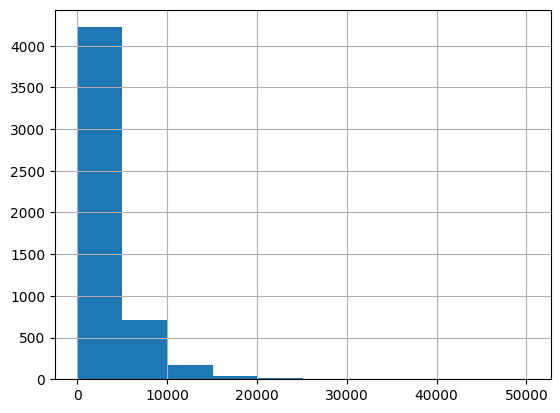

In [15]:
provider_features["StdReimbursement"].hist()
